In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from matplotlib import pyplot as plt


import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../ML_в_бизнесе/Lection3/train_case2.csv', ';')

In [3]:
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), df['cardio'], random_state=0 ) 

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
        
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.key]
    
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[[self.key]]
    
    
class ONEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transformer = Pipeline([('selector', NumberSelector(key=cont_col)),
                           ('standard', StandardScaler())])
    continuos_transformers.append((cont_col, transformer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([('selector', ColumnSelector(key=cat_col)),
                               ('ohe', ONEEncoder(key=cat_col))])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([('selector', NumberSelector(key=base_col))])
    base_transformers.append((base_col, base_transformer))

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

### Задание 1

Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

Применение логистической регрессии

In [7]:

def calculation_of_metric(model, random_state):
    
    classifier = Pipeline([
        ('features', feats),
        ('classifier', model(random_state=random_state)),
    ])


    # запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=7, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score is {cv_score}+-{cv_score_std}')

    # обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    roc_auc_train = roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])

    roc_auc_test = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
    
    return round(thresholds[ix], 3), round(fscore[ix], 3),round(precision[ix], 3), round(recall[ix], 3),roc_auc_test, y_score

In [8]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

CV score is 0.7864573689384385+-0.004422021036885763
Confusion matrix, without normalization
[[4863 3957]
 [1412 7268]]


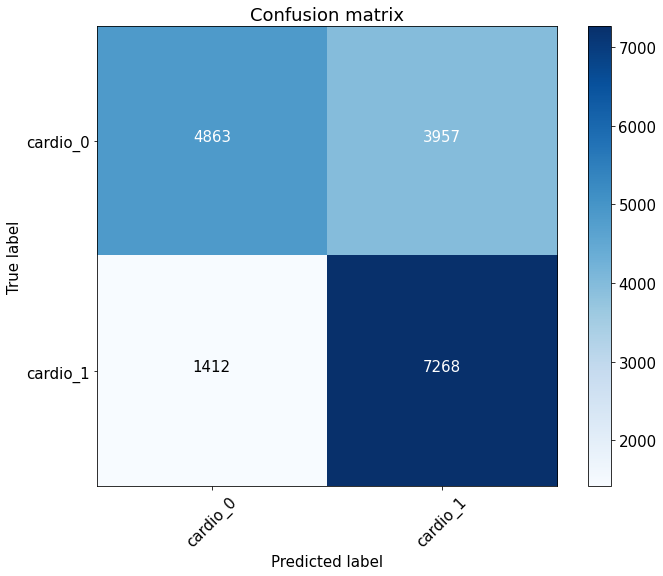

In [9]:
thresholds, fscore, precision, recall, roc_auc_test, y_score = calculation_of_metric(LogisticRegression, 42)
total_df = pd.DataFrame({'model': 'LogisticRegression',
                    'fscore': [fscore],
                    'precision': [precision],
                    'recall': [recall],
                    'roc_auc': [roc_auc_test]})   

font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                     title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [10]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

In [11]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8373271889400922, 0.4486394557823129, 0.5513605442176871)

In [12]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test, rubl_early_treatment, rubl_late_treatment):
    business_threshold = 0
    r_test_all_r_ML_ = 0

    rubl_ML_ = 1_000_000_000 

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        r_test_all_r_ML = rubl_test_all - rubl_ML 
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML) 
        
    plt.title('Потери при МЛ решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs)
    plt.show()
    return business_threshold, rubl_1, rubl_test_all, rubl_ML_

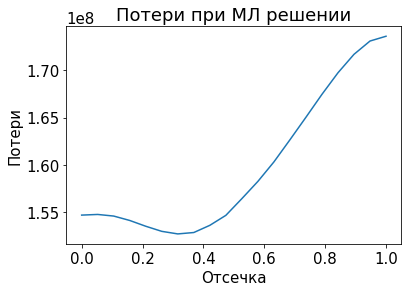

уровень порога по бизнес метрике 0.3157894736842105
уровень порога по f1 метрике 0.387


In [13]:
busines_tr, rubl_1, rubl_test_all, rubl_ML_ = business_threshold_calibrate(y_test, y_score, 
                                          thresholds,
                                          rubl_test=rubl_test, 
                                          rubl_early_treatment=rubl_early_treatment, 
                                          rubl_late_treatment=rubl_late_treatment)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds)

In [14]:
business_metric = pd.DataFrame({'model': 'LogisticRegression',
                            'расходы при позднем лечении (не делать тест)': [rubl_1],
                            'расходы, если делать тест всем и лечить группу больных': [rubl_test_all],
                            'расходы, если использовать МЛ': [rubl_ML_],
                            'разница "не делать тесты - расходы с МL"': [rubl_1 - rubl_ML_],
                            'разница "не делать тесты - сделать тесты всем"': [rubl_1 - rubl_test_all],
                            'разница "сделать тесты всем - решение делать тесты ML"': [rubl_test_all - rubl_ML_]})

### RandomForestClassifier

CV score is 0.7743796633622809+-0.003611330100912611
Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


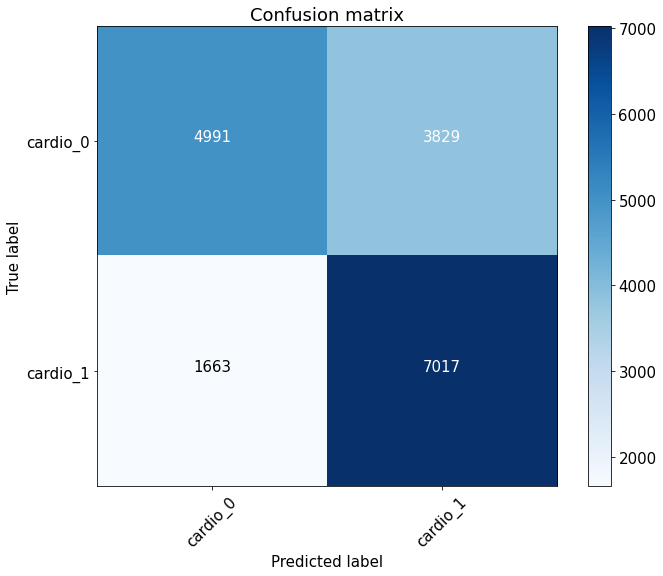

In [15]:
thresholds, fscore, precision, recall, roc_auc_test, y_score = calculation_of_metric(RandomForestClassifier, 42)
total_df = total_df.append({'model': 'RandomForestClassifier',
                    'fscore': fscore,
                    'precision': precision,
                    'recall': recall,
                    'roc_auc': roc_auc_test}, ignore_index=True) 

font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                     title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()


In [16]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8084101382488479, 0.43412698412698414, 0.5658730158730159)

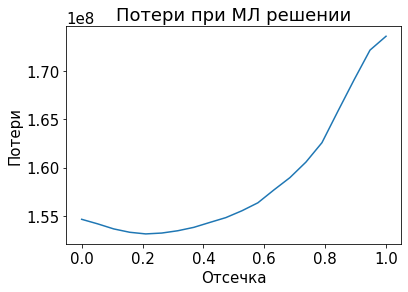

уровень порога по бизнес метрике 0.21052631578947367
уровень порога по f1 метрике 0.35


In [17]:
busines_tr, rubl_1, rubl_test_all, rubl_ML_ = business_threshold_calibrate(y_test, y_score, 
                                          thresholds,
                                          rubl_test=rubl_test, 
                                          rubl_early_treatment=rubl_early_treatment, 
                                          rubl_late_treatment=rubl_late_treatment)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds)

In [18]:
business_metric = business_metric.append({'model': 'DecisionTreeClassifier',
                            'расходы при позднем лечении (не делать тест)': rubl_1,
                            'расходы, если делать тест всем и лечить группу больных': rubl_test_all,
                            'расходы, если использовать МЛ': rubl_ML_,
                            'разница "не делать тесты - расходы с МL"': rubl_1 - rubl_ML_,
                            'разница "не делать тесты - сделать тесты всем"': rubl_1 - rubl_test_all,
                            'разница "сделать тесты всем - решение делать тесты ML"': rubl_test_all - rubl_ML_}, 
                                         ignore_index=True)

### XGBClassifier

[22:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

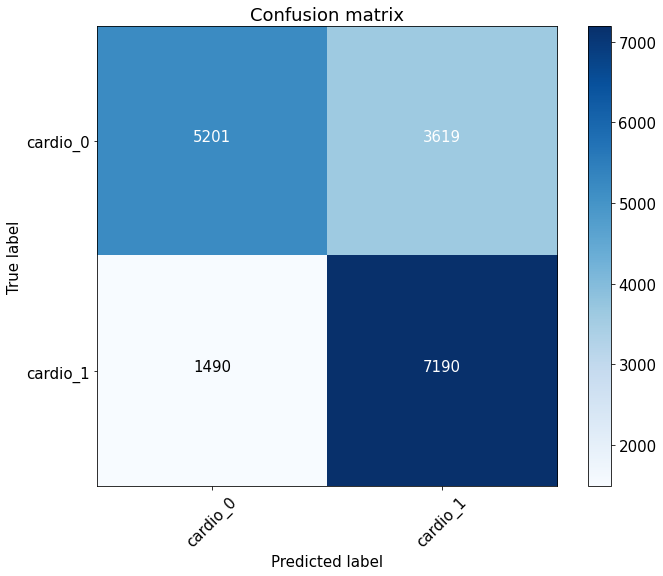

In [19]:
thresholds, fscore, precision, recall, roc_auc_test, y_score = calculation_of_metric(XGBClassifier, 42)
total_df = total_df.append({'model': 'XGBClassifier',
                    'fscore': fscore,
                    'precision': precision,
                    'recall': recall,
                    'roc_auc': roc_auc_test}, ignore_index=True) 

font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score > thresholds)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                     title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [20]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8283410138248848, 0.4103174603174603, 0.5896825396825397)

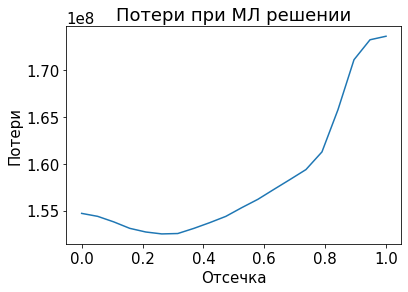

уровень порога по бизнес метрике 0.2631578947368421
уровень порога по f1 метрике 0.347


In [21]:
busines_tr, rubl_1, rubl_test_all, rubl_ML_ = business_threshold_calibrate(y_test, y_score, 
                                          thresholds,
                                          rubl_test=rubl_test, 
                                          rubl_early_treatment=rubl_early_treatment, 
                                          rubl_late_treatment=rubl_late_treatment)

print('уровень порога по бизнес метрике', busines_tr)
print('уровень порога по f1 метрике', thresholds)

In [22]:
business_metric = business_metric.append({'model': 'XGBClassifier',
                            'расходы при позднем лечении (не делать тест)': rubl_1,
                            'расходы, если делать тест всем и лечить группу больных': rubl_test_all,
                            'расходы, если использовать МЛ': rubl_ML_,
                            'разница "не делать тесты - расходы с МL"': rubl_1 - rubl_ML_,
                            'разница "не делать тесты - сделать тесты всем"': rubl_1 - rubl_test_all,
                            'разница "сделать тесты всем - решение делать тесты ML"': rubl_test_all - rubl_ML_},
                                        ignore_index=True)

### Задание 2

Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [23]:
total_df

,model,fscore,precision,recall,roc_auc
0,LogisticRegression,0.730,0.647,0.838,0.784035
1,RandomForestClassifier,0.719,0.643,0.816,0.771037
2,XGBClassifier,0.738,0.665,0.828,0.797228


### Задание 3

Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока:
- стоимость лечения 15000р, если сделали тест и начали лечить вовремя;
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы;
- стоимость теста 1400р

In [24]:
business_metric

,model,расходы при позднем лечении (не делать тест),"расходы, если делать тест всем и лечить группу больных","расходы, если использовать МЛ","разница ""не делать тесты - расходы с МL""","разница ""не делать тесты - сделать тесты всем""","разница ""сделать тесты всем - решение делать тесты ML"""
0,LogisticRegression,173600000,154700000,152712400,20887600,18900000,1987600
1,DecisionTreeClassifier,173600000,154700000,153132800,20467200,18900000,1567200
2,XGBClassifier,173600000,154700000,152509800,21090200,18900000,2190200


### Задание 4

Лучший recall вышел у модели лог.регрессии, но по бизнес метрикам XGBoost вышел на первое место.При данной модели расходы получаются меньше.

### Задание 5

Найти порог классификации по деньгам для лучшей модели

Уровень порога по бизнес метрике для модели XGBoost составил 0.263 (он был посчитан в 1-ом задании)